### Bibliotecas

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import osmnx as ox
import networkx as nx
from itertools import combinations
import os
import re
import rasterio
from rasterio.mask import mask
import shutil
import zipfile
from pathlib import Path
from pyproj import Transformer
import multiprocessing as mp

print(f'Utilizando a versão {ox.__version__} do OSMNX')

print(f'Eu tenho {mp.cpu_count()} CPUs disponíveis')

Utilizando a versão 2.0.1 do OSMNX
Eu tenho 8 CPUs disponíveis


### Parâmetros

In [43]:
caminho = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/6_Qualificação/Mapas temáticos e figuras/BACIA_HIDROGRAFICA/SIRGAS_BACIAHIDROGRAFICA.shp'

my_crs = 'epsg:4326'  # Verificar em EPSG.io um projeção que te dê o resultado em metros

pesquisa_OD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Pesquisa OD 2017/OD-2017/Mapas-OD2017/Shape-OD2017'
#'/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/My Drive/Pesquisa OD 2017/OD-2017/Mapas-OD2017/Shape-OD2017/Zonas_2017_region.shp'

plt.style.use('ggplot')

arquivo_matrizOD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Pesquisa OD 2017/OD-2017/Tabelas-OD2017/Tab25_OD2017.xlsx'
#'/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/My Drive/Pesquisa OD 2017/OD-2017/Tabelas-OD2017/Tab25_OD2017.xlsx'

verbose = True  # Flag para pular algumas atividades, com o objetivo de economizar memória.

ox.settings.log_console = True
ox.settings.use_cache = True

In [94]:
# Carregar o grafo de um arquivo GraphML e o bounding box
try:
    G_baseline = ox.load_graphml(filepath='network_baseline_vel_updated.graphml')
    print('Grafo carregado com sucesso!')
except:
    print('Arquivo não encontrado')

try:
    bounding_box_baseline = gpd.read_file('bounding_box_bacia.json')
    print('Bounding box carregado com sucesso!')
except:
    print('Bounding box não encontrado')
    
node_baseline, edges_baseline = ox.graph_to_gdfs(G_baseline)

Grafo carregado com sucesso!
Bounding box carregado com sucesso!


In [6]:
edges_baseline.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 8333 entries, (np.int64(597447), np.int64(25778775), np.int64(0)) to (np.int64(12013065742), np.int64(1269523805), np.int64(0))
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      8333 non-null   object  
 1   oneway     8333 non-null   bool    
 2   lanes      7167 non-null   object  
 3   ref        203 non-null    object  
 4   name       7047 non-null   object  
 5   highway    8333 non-null   object  
 6   maxspeed   2906 non-null   object  
 7   reversed   8333 non-null   object  
 8   length     8333 non-null   float64 
 9   geometry   8333 non-null   geometry
 10  speed_kph  8333 non-null   float64 
 11  bridge     270 non-null    object  
 12  access     37 non-null     object  
 13  tunnel     12 non-null     object  
 14  junction   263 non-null    object  
 15  est_width  38 non-null     object  
 16  width      13 non-null     object  
dt

### Carregar os pontos da pesquisa OD referentes a bacia

In [36]:
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS, Transformer

# Read the shapefile
gdf_OD = gpd.read_file(pesquisa_OD)

# You need to understand Geographic coordinate systems and Projected coordinate systems.
# Geographic CRS(such as 'EPSG:4326') is not suitable for measuring distance. 
# Converting degree to distance requires additional work. 
# Use a different coordinate as the warning message shows. 
# The coordinates you usually use depend on the area you want to analyze.
# It will be common to use a coordinate system based on UTM.
    
# Verifica o sistema de coordenadas
gdf_OD.crs

# Define the UTM Zone 23S coordinate system
utm_crs = CRS("EPSG:32723")  # UTM Zone 23S, southern hemisphere

# Atribuição do esquema de projeção
gdf_OD_utm = gdf_OD.to_crs(utm_crs)

# Filtrando para o munícipio de São Paulo
gdf_OD_SP_utm = gdf_OD_utm[gdf_OD_utm['NomeMunici'] == 'São Paulo'].copy()

# Obtendo os centroides
gdf_OD_SP_utm["centroid"] = gdf_OD_SP_utm["geometry"].centroid

if verbose:
    mapa_centroides = gdf_OD_SP_utm['centroid'].explore()
    mapa_centroides.save('mapa_centroides_SP.html')

/Users/marcelofernandes/PycharmProjects/SP_urban_flooding/venv/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'Shape-OD2017': 'Zonas_2017_region' (default), 'Distritos_2017_region', 'Municipios_2017_region'. Specify layer parameter to avoid this warning.
  result = read_func(


(65, 3)
EPSG:32723


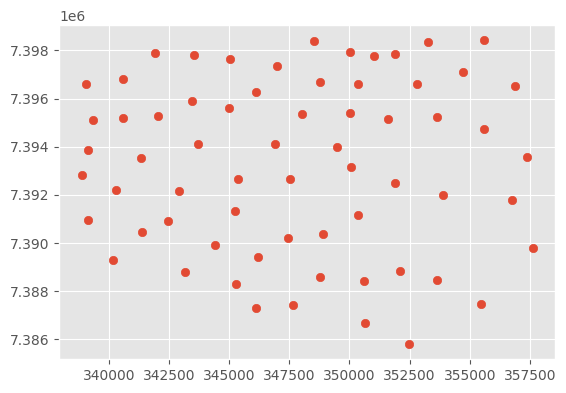

In [37]:
# Atribuição do esquema de projeção
bounding_box_baseline_utm = bounding_box_baseline.to_crs(utm_crs)

centroides_df = gpd.GeoDataFrame(gdf_OD_SP_utm[['NumeroZona', 'NomeZona']], geometry=gdf_OD_SP_utm['centroid'])
centroides_dentro = gpd.sjoin(centroides_df, bounding_box_baseline_utm, how='inner', predicate='within')

# Remover a coluna de índice criada pelo sjoin
centroides_dentro = centroides_dentro.drop(columns=['index_right'])

# Redefinir o índice
centroides_dentro = centroides_dentro.reset_index(drop=True)

if verbose:
    print(centroides_dentro.shape)
    print(centroides_dentro.crs)
    centroides_dentro.plot()

In [38]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

G_baseline_utm = ox.project_graph(G_baseline, to_crs='EPSG:32723')

# 1. Aproximar os pontos de centroides_dentro à rede
centroides_dentro['nearest_node_baseline'] = centroides_dentro['geometry'].apply(
    lambda point: ox.distance.nearest_nodes(G_baseline_utm, point.x, point.y)
)

# Função para obter coordenadas dos nós
def get_node_coords(node_id):
    node = G_baseline_utm.nodes[node_id]
    return (node['x'], node['y'])

# Adicionar coordenadas dos nós ao DataFrame
centroides_dentro['node_coords'] = centroides_dentro['nearest_node_baseline'].apply(get_node_coords)

# Separar coordenadas em colunas distintas
centroides_dentro[['node_x', 'node_y']] = pd.DataFrame(centroides_dentro['node_coords'].tolist(), index=centroides_dentro.index)

# Criar geometria dos pontos para o novo GeoDataFrame
geometry = [Point(xy) for xy in zip(centroides_dentro['node_x'], centroides_dentro['node_y'])]

# Criar o GeoDataFrame
gdf_nos_aproximados = gpd.GeoDataFrame(centroides_dentro, geometry=geometry)

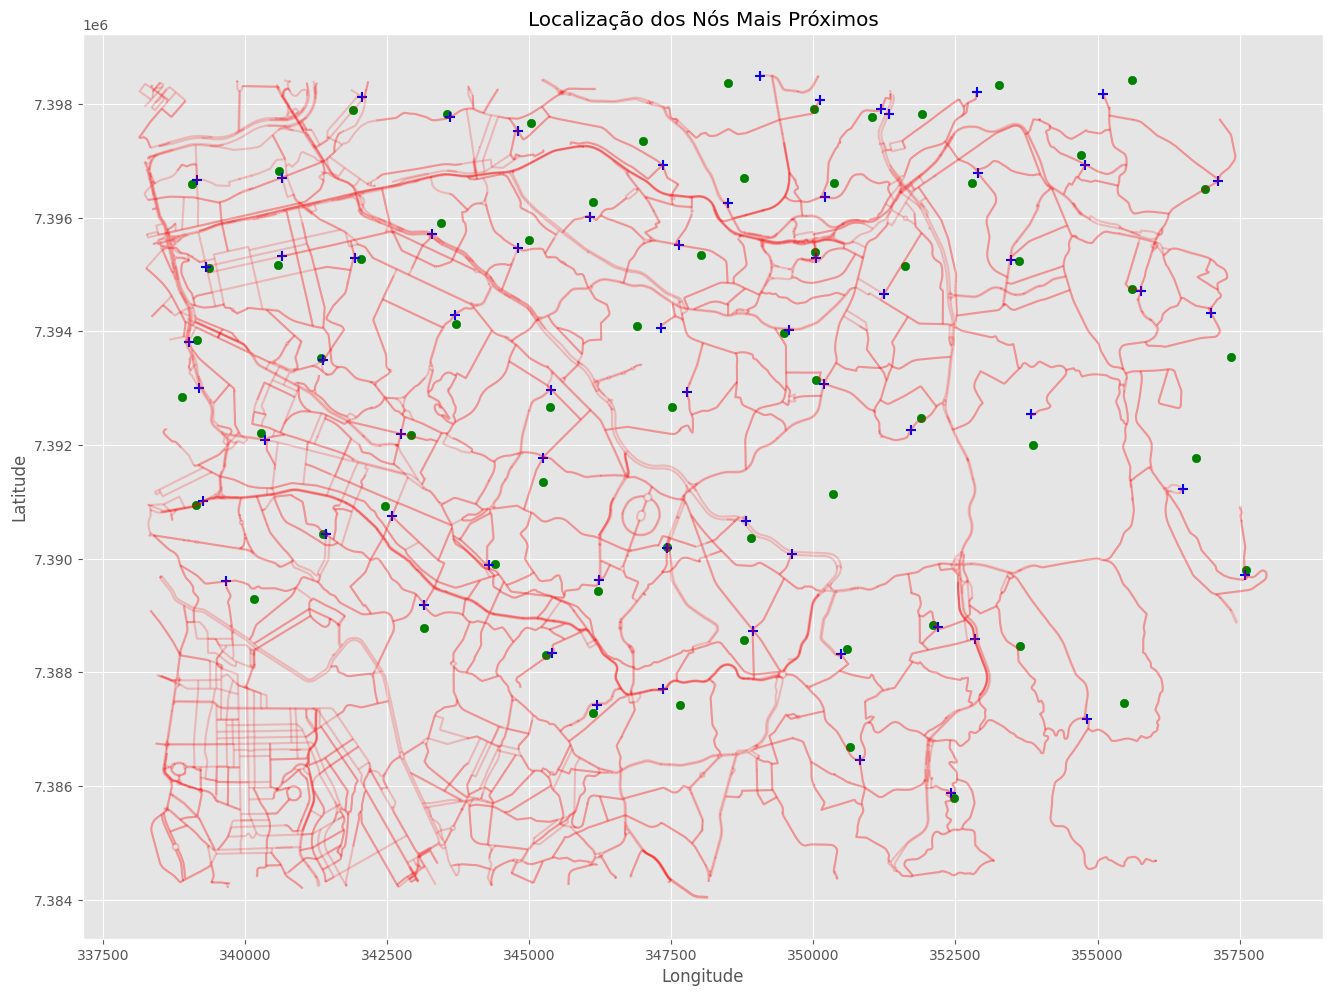

In [39]:
# Atribuição do esquema de projeção
edges_baseline_utm = edges_baseline.to_crs(utm_crs)
gdf_nos_aproximados_utm = gdf_nos_aproximados.to_crs(utm_crs)

# Verificação gráfica do resultado
base2 = centroides_dentro.plot(color='green', figsize=(16,16))

edges_baseline_utm.plot(ax=base2, color='red', alpha=0.2)

gdf_nos_aproximados.plot(ax=base2, marker='+', color='blue', markersize=50)
plt.title('Localização dos Nós Mais Próximos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Calcular o baseline (caminhos mínimos, sem chuva)

In [28]:
def listar_atributos_arestas(G):
    atributos = set()
    for _, _, dados in G.edges(data=True):
        atributos.update(dados.keys())
    return atributos

In [16]:
# Função para adicionar tempo de viagem às arestas
def add_edge_travel_times(G, referencia, comentarios):
    if comentarios:
        print('\nIniciando o cálculo do tempo de viagem.\n')
    for u, v, key, data in G.edges(keys=True, data=True):
        length = data.get('length', 0)  # Certifique-se de que length esteja definido
        vel_ref = data.get(referencia, 0)  # Certifique-se de que vel_ref esteja definido
        
        if vel_ref == 0:
            travel_time_ref = float('inf')  # Indica que o tempo de viagem é infinito
        else:
            travel_time_ref = (length*3.6) / vel_ref  #*(3600/1000)  # Convertendo para segundos
        nome = 'travel_time_' + referencia
        G.edges[u, v, key][nome] = travel_time_ref
        #print(f'Aresta ({u}, {v}, {key}): {data}')
    
    if comentarios:
        print('Cálculo do tempo de viagem concluído.\n')
        print('Removendo arestas cujo tempo de viagem é igual a infinito...\n')
    edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if data.get(nome) == float('inf')]
    print(f'Arestas a serem removidas: {len(edges_to_remove)} de {len(G.edges)}')
    # Remover as arestas com tempo de viagem igual a infinito
    G.remove_edges_from(edges_to_remove)
    if comentarios:
        print(f'{len(edges_to_remove)} aresta(s) removida(s).\n')
    return G

In [17]:
# Adicionar velocidade aos eixos e calcular o tempo de viagem
referencia = 'speed_kph'
G_mod = add_edge_travel_times(G_baseline, referencia, comentarios=True)


Iniciando o cálculo do tempo de viagem.

Cálculo do tempo de viagem concluído.

Removendo arestas cujo tempo de viagem é igual a infinito...

Arestas a serem removidas: 0 de 8333
0 aresta(s) removida(s).



In [18]:
listar_atributos_arestas(G_mod)

{'access',
 'bridge',
 'est_width',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'ref',
 'reversed',
 'speed_kph',
 'travel_time_speed_kph',
 'tunnel',
 'width'}

In [46]:
import pandas as pd
import itertools
import time

# Carregar a planilha no DataFrame
# Considerando que a primeira linha contém os cabeçalhos e as zonas começam de 1
matriz_od_25 = pd.read_excel(arquivo_matrizOD, header=7, index_col=0)
# Exibir as primeiras linhas do DataFrame para verificação
#print(matriz_od_25.head())

# 1. Função para obter o número de viagens da matriz OD
def get_number_of_trips(node1, node2, referencia, od_matrix):
    zone1 = centroides_dentro.loc[centroides_dentro[referencia] == node1, 'NumeroZona'].values[0]
    zone2 = centroides_dentro.loc[centroides_dentro[referencia] == node2, 'NumeroZona'].values[0]
    return od_matrix.loc[zone1, zone2]

# 2. Definição da função para encontrar o caminho mínimo
def caminho_minimo(G, source, target, weight):
    # Encontrar o caminho mais curto
    path = nx.shortest_path(G, source=source, target=target, weight=weight)
    path_cost = nx.path_weight(G, path, weight=weight)
    return path, path_cost

In [20]:
 def calcula_caminho_minimo(gdf_OD, referencia_OD, G, referencia, comentarios):
    data = 0
    data_batch = []
    start_time = time.time()
    sem_caminho = []  # Lista para armazenar pares sem caminho

    if comentarios:
        print('\nIniciando o cálculo do caminho mínimo médio.')
        print(f'A referência fornecida para o cálculo do custo é {referencia_OD}')
    for node1, node2 in itertools.product(gdf_OD[referencia_OD], repeat=2):
        if node1 == node2:
            continue  # Ignorar pares onde origem e destino são iguais
        try:
            # Obter o número de viagens entre node1 e node2
            num_trips = get_number_of_trips(node1, node2, referencia_OD, matriz_od_25)
            if num_trips > 0:
                # Calcular o caminho mínimo pelo tempo de viagem ponderado
                if node1 in G.nodes and node2 in G.nodes:
                    # Calcular o caminho mais curto
                    caminho, tempo = caminho_minimo(G, node1, node2, referencia)
                    weighted_time_rain = tempo * num_trips
                else:
                    print(f"Nó(s) {node1} ou {node2} não encontrado(s) no grafo.")
                    continue
                data_batch.append({
                    'index': data + 1,
                    'Referência': referencia,
                    'Origem': node1,
                    'Destino': node2,
                    'Num_viagens': num_trips,
                    'Tempo de viagem (min)': tempo / 60,
                    'Número de nós': len(caminho),
                    'Percurso entre nós': list(caminho),
                    'Tempo ponderado sem chuva (min)': weighted_time_rain / 60
                        })
                data += 1

        except nx.NetworkXNoPath:
            # Se não houver caminho entre os nós, registre a ocorrência
            sem_caminho.append((node1, node2))
            continue
            
    # Parar o cronômetro e calcular o tempo de processamento
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"Tempo de processamento: {processing_time:.2f} segundos")
    print(f'Foram calculadas {data} viagens')
            
    # Criar DataFrame e salvar em CSV
    tempos_e_viagens_arquivo = pd.DataFrame(data_batch)
    return tempos_e_viagens_arquivo, sem_caminho  # Retorna também a lista de pares sem caminho

In [18]:
tempos_e_viagens_arquivo = calcula_caminho_minimo(centroides_dentro,'nearest_node_baseline', G_mod, 'travel_time_speed_kph',comentarios=True)


Iniciando o cálculo do caminho mínimo médio.
A referência fornecida para o cálculo do custo é nearest_node_baseline
Tempo de processamento: 7.14 segundos
Foram calculadas 851 viagens


In [19]:
import numpy as np

# Filtrar os valores finitos para tempo com peso e num_viagens
finite_mask_baseline = np.isfinite(tempos_e_viagens_arquivo['Tempo ponderado sem chuva (min)'])
finite_tempos_e_viagens_baseline = tempos_e_viagens_arquivo[finite_mask_baseline]

# Calcular o número total de viagens sem valores infinitos
total_trips_weighted = finite_tempos_e_viagens_baseline['Num_viagens'].sum()

# Calcular o tempo total sem peso ignorando valores infinitos
total_time_weighted = finite_tempos_e_viagens_baseline['Tempo ponderado sem chuva (min)'].sum()

# Calcular o tempo médio de viagem ponderado
mean_time_weighted = total_time_weighted / total_trips_weighted

# Exibir os resultados
print(f"Tempo médio de viagem sem chuva e ponderado: {mean_time_weighted:.2f} minutos")


Tempo médio de viagem sem chuva e ponderado: 7.26 minutos


In [20]:
# Padronização dos números
tempos_e_viagens_arquivo['Num_viagens'] = tempos_e_viagens_arquivo['Num_viagens'].apply(lambda x: f"{x:.2f}")
tempos_e_viagens_arquivo['Tempo de viagem (min)'] = tempos_e_viagens_arquivo['Tempo de viagem (min)'].apply(lambda x: f"{x:.2f}")
tempos_e_viagens_arquivo['Tempo ponderado sem chuva (min)'] = tempos_e_viagens_arquivo['Tempo ponderado sem chuva (min)'].apply(lambda x: f"{x:.2f}")

In [21]:
# Salva o arquivo localmente
tempos_e_viagens_arquivo.to_csv('dados_caminho_minimo_sem_chuva.csv', encoding='utf-8', index=False)  # index=False para não incluir a coluna de índices no CSV

In [21]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point

def get_node_coords(G, node):
    """Função para obter as coordenadas do nó."""
    x = G.nodes[node]['x']
    y = G.nodes[node]['y']
    print('Nós: Para o grafo informado, o sistema de referência de coordenadas é: ', G.graph['crs'])
    return (x, y)

def mostra_caminho_minimo(df, indice_linha, G):
    # Extraindo a linha específica do DataFrame
    linha = df.iloc[indice_linha]
    origem = linha['Origem']
    destino = linha['Destino']
    percurso = linha['Percurso entre nós']
    tempo = linha['Tempo de viagem (min)']
    print(f'O tempo deste caminho mínimo foi de: {tempo} minutos')
   
    print('Caminho: Para o grafo informado, o sistema de referência de coordenadas é: ', G.graph['crs'])

    # Converter o grafo em GeoDataFrame
    points, line = momepy.nx_to_gdf(G)

    # Plotar o grafo
    fig, ax = plt.subplots(figsize=(12, 12))
    line.plot(ax=ax, edgecolor='lightgrey', linewidth=0.5)
    
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:31983", always_xy=True)
    
    # Plotar o caminho em amarelo
    caminho = G.subgraph(percurso)
    caminho_edges = list(caminho.edges(data=True))

    caminho_edges_transformado = []

    for u, v, data in caminho_edges:
        x1, y1 = transformer.transform(G_chuva1.nodes[u]['x'], G_chuva1.nodes[u]['y'])
        x2, y2 = transformer.transform(G_chuva1.nodes[v]['x'], G_chuva1.nodes[v]['y'])
        caminho_edges_transformado.append(((x1, y1), (x2, y2)))

    for (x1, y1), (x2, y2) in caminho_edges_transformado:
        ax.plot([x1, x2], [y1, y2], color='yellow', linewidth=2, alpha=0.7)
    
    # Plotar o ponto de origem em vermelho e o ponto de destino em verde
    origem_coords = get_node_coords(G, origem)
    destino_coords = get_node_coords(G, destino)

    origem_coords = transformer.transform(*origem_coords)
    destino_coords = transformer.transform(*destino_coords)

    ax.scatter(*origem_coords, color='red', s=100, label='Origem')
    ax.scatter(*destino_coords, color='green', s=100, label='Destino')

    plt.show()

    return

O tempo deste caminho mínimo foi de: 22.94 minutos
Caminho: Para o grafo informado, o sistema de referência de coordenadas é:  EPSG:32723


/var/folders/8y/8z4lzw294m5c0kf05d8ww4r00000gn/T/ipykernel_5603/2424049454.py:27: UserWarning: Approach is not set. Defaulting to 'primal'.
  points, line = momepy.nx_to_gdf(G)


Nós: Para o grafo informado, o sistema de referência de coordenadas é:  EPSG:32723
Nós: Para o grafo informado, o sistema de referência de coordenadas é:  EPSG:32723


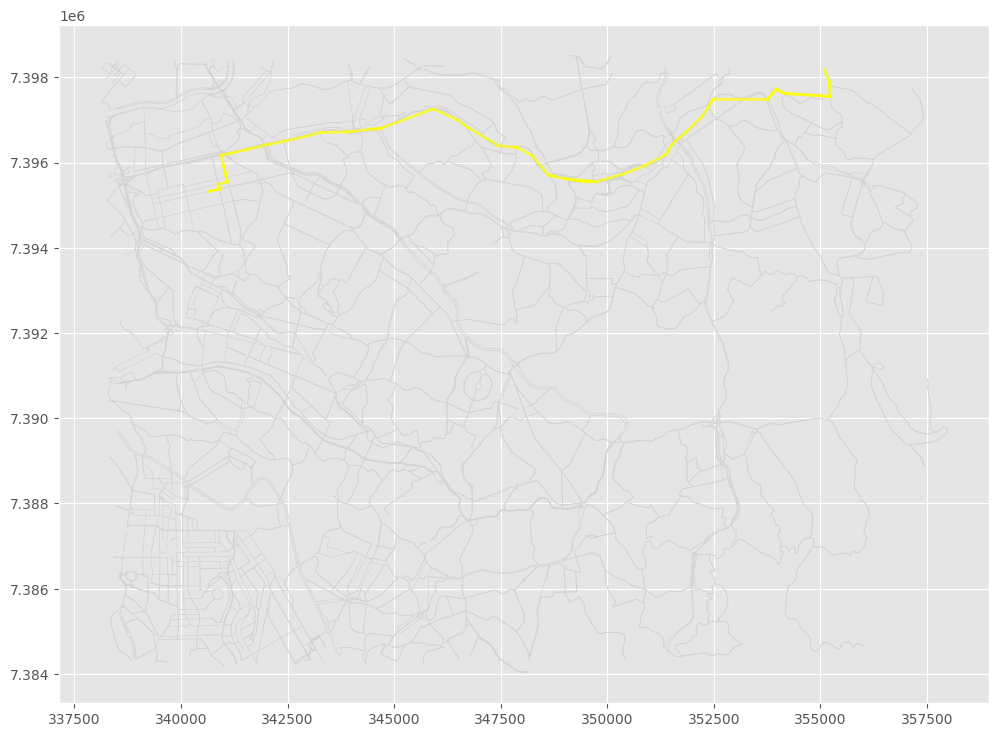

In [127]:
mostra_caminho_minimo(tempos_e_viagens_arquivo, 48, G_baseline_utm)

In [24]:
tempos_e_viagens_arquivo

,index,Origem,Destino,Num_viagens,Tempo de viagem (min),Número de nós,Percurso entre nós,Tempo ponderado sem chuva (min)
0,1,340185206,4499663530,1322.71,3.34,15,"[340185206, 910203189, 1759958160, 340185200, ...",4418.69
1,2,340185206,458457689,696.85,3.05,12,"[340185206, 910203189, 1759958160, 340185200, ...",2122.60
2,3,340185206,129958225,520.90,7.47,35,"[340185206, 910203189, 340185209, 1759750087, ...",3893.37
3,4,340185206,130009969,433.08,6.09,31,"[340185206, 910203189, 1759958160, 340185200, ...",2637.97
4,5,340185206,433999406,126.22,9.66,43,"[340185206, 910203189, 1759958160, 340185200, ...",1219.56
...,...,...,...,...,...,...,...,...
846,847,1645957962,1071641620,522.66,8.88,42,"[1645957962, 1607796908, 1645958012, 794096211...",4641.87
847,848,1645957962,1040335345,459.69,4.87,29,"[1645957962, 1645957987, 1645958516, 296948233...",2238.63
848,849,1645957962,6358057222,1482.04,3.08,18,"[1645957962, 1645957987, 1645958516, 296948233...",4561.86
849,850,1645957962,1095092347,343.05,6.63,24,"[1645957962, 1645957987, 1645958516, 296948233...",2273.44


In [25]:
tempos_e_viagens_arquivo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   index                            851 non-null    int64 
 1   Origem                           851 non-null    int64 
 2   Destino                          851 non-null    int64 
 3   Num_viagens                      851 non-null    object
 4   Tempo de viagem (min)            851 non-null    object
 5   Número de nós                    851 non-null    int64 
 6   Percurso entre nós               851 non-null    object
 7   Tempo ponderado sem chuva (min)  851 non-null    object
dtypes: int64(4), object(4)
memory usage: 53.3+ KB


### Cálculo de caminho mínimo com chuva

Script para calcular os caminhos mínimos em situações com chuva.

#### Bibliotecas

#### Parâmetros do processo de cálculo

In [8]:
# Caminhos e arquivo de entrada
input_zip_file = r'/Volumes/Dados_na_nuvem/Marcelo/Mestrado PTR/pct1_h_files.zip'
output_folder = r'/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/9_Dissertação/Resultados'
pesquisa_OD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/My Drive/Pesquisa OD 2017/OD-2017/Mapas-OD2017/Shape-OD2017/Zonas_2017_region.shp'
my_crs = '4326' # Verificar em EPSG.io um projeção que te dê o resultado em metros

# Parâmetros
pacote_num = 1          # Número do pacote a ser criado
bacia_nome = "Aricanduva"  # Nome da bacia

# Diretórios e configurações
pacote_path = os.path.join(output_folder, f"Pacote_{pacote_num:02d}")
raw_path = os.path.join(pacote_path, "Raw")
bacias_path = os.path.join(pacote_path, "Bacias", bacia_nome)
clipado_path = os.path.join(bacias_path, "Clipado") # Diretório para salvar os arquivos clipados

# Determinar os pixels acima do threshold
threshold = 70  # Valor informado em milímetros, mas convertido para metros, em função do raster. Valor obtido a partir da IC do Rodrigo.
threshold_max = 300 # Valor obtido a partir do paper da Pregnolato. Novamente, valor informado em milímetros, mas convertido para metros.

#### Separando um único arquivo para testes

In [67]:
# Por enquanto, somente um arquivo está sendo utilizado, até que a lógica esteja funcional.
filename = os.listdir(clipado_path)[5] # Neste momento, só estou operando com um arquivo de chuva.

# Extrair informações do nome do arquivo
match = re.search(r'pct(?P<pct>\d+)_h(?:_max)?_(?P<value>\d+)_clp', filename)
if match:
    pct = match.group('pct')  # Valor após "pct"
    value = match.group('value')  # Valor numérico
    is_max = '_max' in filename  # Verificar se "max" está presente
            
# Criar o nome da coluna dinamicamente
column_suffix = f"pct{pct}_h_{value}" + ("_max" if is_max else "")
column_name = column_suffix  # Exemplo: "pct1_h_2692800" ou "pct1_h_max_2768400"
print('\nO nome da nova coluna é:', column_name)
            
# Caminho completo do arquivo raster
raster_path = os.path.join(clipado_path, filename)
print(raster_path)



O nome da nova coluna é: pct1_h_2768400_max
/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/9_Dissertação/Resultados/Pacote_01/Bacias/Aricanduva/Clipado/pct1_h_max_2768400_clp.tif
CRS atual do edges_baseline: epsg:4326
CRS do edges_baseline_reprojected: EPSG:31983


In [95]:

# Verificar o CRS atual
print("CRS atual do edges_baseline:", edges_baseline.crs)

# Reprojetar para EPSG:31983
edges_baseline_reprojected = edges_baseline.to_crs(epsg=31983)

# Verificar se a reprojeção foi bem-sucedida
print("CRS do edges_baseline_reprojected:", edges_baseline_reprojected.crs)

CRS atual do edges_baseline: epsg:4326
CRS do edges_baseline_reprojected: EPSG:31983


####  1o passo: construir uma nova referência de velocidade

In [15]:
def adjust_speed_batch(row, raster_data, transform, threshold, threshold_max, speed_column):
    """
    Ajusta a velocidade de um segmento com base na profundidade do alagamento extraída de um raster.

    Parâmetros:
        row (GeoSeries): Linha atual do GeoDataFrame contendo informações de velocidade e geometria.
        raster_data (numpy.ndarray): Dados do raster contendo profundidade de alagamento.
        transform (Affine): Transformação do raster para coordenadas espaciais.
        threshold (float): Profundidade mínima para ajustar a velocidade.
        threshold_max (float): Profundidade máxima que torna a via intransitável.
        speed_column (str): Nome da coluna de referência para a velocidade original.
    
    Retorno:
        float: Velocidade ajustada para o segmento.
    """

    # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid

    # Transformar as coordenadas do centroide em índices do raster
    try:
        col_idx, row_idx = ~transform * (centroid.x, centroid.y) # Observe a ordem inversa
        row_idx, col_idx = int(row_idx), int(col_idx)
    except Exception:
        # Caso algo dê errado na transformação, manter a velocidade original
        #print('Mantive a velocidade que veio!')
        return row[speed_column]

    # Verificar se os índices estão dentro dos limites do raster
    if not (0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]):
        print(row_idx, raster_data.shape[0], col_idx, raster_data.shape[1])
        return row[speed_column]
    
    # Extração do valor de profundidade do raster
    flood_depth = 1000*raster_data[row_idx, col_idx] # Valor extraído do raster em metros
    #print(flood_depth)

    # Ajustar a velocidade com base na profundidade
    if flood_depth > threshold_max:
        # Caso a altura exceda o limiar máximo, torna-se instransitável
        return 0
    elif flood_depth > threshold:
        # Aplicar a fórmula de ajuste da velocidade
        adjusted_speed = 0.0009 * (flood_depth ** 2) - 0.5529 * flood_depth + 86.9448
        #print('Pregnolato!')
        return min(adjusted_speed, row[speed_column])  # Garantir que não ultrapasse a velocidade original
        
    # Caso contrário, manter a velocidade original
    return row[speed_column]

In [77]:
# Abrir o raster e extrair os dados
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Ler a primeira banda do raster
    raster_transform = src.transform   


# Aplicar a função de ajuste e criar uma nova coluna
edges_baseline_reprojected[column_name] = edges_baseline_reprojected.apply(
    adjust_speed_batch,
    axis=1,
    args=(raster_data, raster_transform, threshold, threshold_max, 'speed_kph')
    )

# Verifique se a nova coluna foi adicionada:
print(edges_baseline_reprojected.columns)

Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Pregnolato!
Preg

####  2o passo: converter o GDF em OSMnx, incluindo a nova referência de velocidade

MultiDiGraph with 4453 nodes and 8333 edges


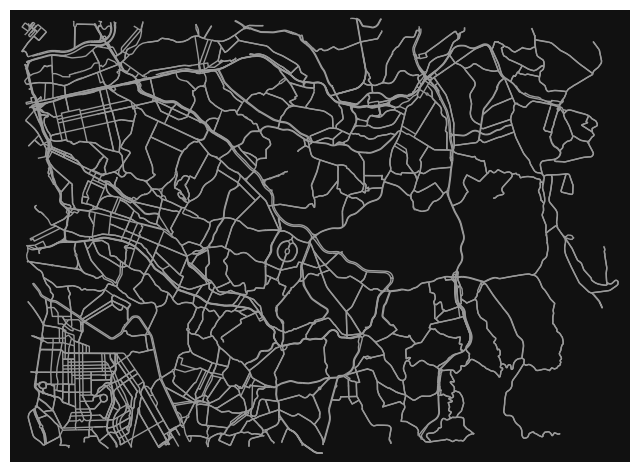

O sistema de referência de coordenadas do grafo é: EPSG:31983


In [97]:
import osmnx as ox

# Garantir que os nós tenham colunas 'x' e 'y' extraídas da geometria
node_baseline["x"] = node_baseline.geometry.x
node_baseline["y"] = node_baseline.geometry.y

# Convert GDFs to OSMnx Graph
G_chuva = ox.graph_from_gdfs(node_baseline, edges_baseline_reprojected)

print(G_chuva)
ox.plot_graph(G_chuva)

# Verificar que a coluna do raster foi adicionada
listar_atributos_arestas(G_chuva)

# Verificar o sistema de referência de coordenadas
crs = G_chuva.graph['crs']
print('O sistema de referência de coordenadas do grafo é:', crs)

####  3o passo: calcular os tempos de viagens, considerando a nova referência de velocidade

In [81]:
G_chuva1 = add_edge_travel_times(G_chuva, column_name, comentarios=True)
listar_atributos_arestas(G_chuva1)


Iniciando o cálculo do tempo de viagem.

Cálculo do tempo de viagem concluído.

Removendo arestas cujo tempo de viagem é igual a infinito...

1 aresta(s) removida(s).



{'access',
 'bridge',
 'est_width',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'pct1_h_2768400_max',
 'ref',
 'reversed',
 'speed_kph',
 'travel_time_pct1_h_2768400_max',
 'tunnel',
 'width'}

####  4o passo: calcular o caminho mínimo

In [145]:
print('\nSistema de coordenadas original dos centroides: ', centroides_dentro.crs)
centroides_dentro_reproj = centroides_dentro.to_crs(31983)
print('\nSistema de coordenadas reprojetado dos centroides: ', centroides_dentro_reproj.crs)
tempos_e_viagens_chuva_arquivo, sem_caminho = calcula_caminho_minimo(centroides_dentro,'nearest_node_baseline', G_chuva1, 'travel_time_pct1_h_2768400_max',comentarios=True)


Sistema de coordenadas original dos centroides:  EPSG:32723

Sistema de coordenadas reprojetado dos centroides:  EPSG:31983

Iniciando o cálculo do caminho mínimo médio.
A referência fornecida para o cálculo do custo é nearest_node_baseline
Tempo de processamento: 7.55 segundos
Foram calculadas 709 viagens


In [147]:
len(sem_caminho)

201

In [48]:
import numpy as np

def tempo_medio_viagem(arquivo):

    # Filtrar os valores finitos para tempo com peso e num_viagens
    finite_mask_baseline = np.isfinite(arquivo['Tempo ponderado sem chuva (min)'])
    finite_tempos_e_viagens_chuva_baseline = arquivo[finite_mask_baseline]

    # Calcular o número total de viagens sem valores infinitos
    total_trips_weighted = finite_tempos_e_viagens_chuva_baseline['Num_viagens'].sum()

    # Calcular o tempo total sem peso ignorando valores infinitos
    total_time_weighted = finite_tempos_e_viagens_chuva_baseline['Tempo ponderado sem chuva (min)'].sum()

    # Calcular o tempo médio de viagem ponderado
    mean_time_weighted = total_time_weighted / total_trips_weighted

    # Exibir os resultados
    print(f"Tempo médio de viagem com chuva e ponderado: {mean_time_weighted:.2f} minutos")

    return mean_time_weighted

In [102]:
# Padronização dos números
tempos_e_viagens_chuva_arquivo['Num_viagens'] = tempos_e_viagens_chuva_arquivo['Num_viagens'].apply(lambda x: f"{x:.2f}")
tempos_e_viagens_chuva_arquivo['Tempo de viagem (min)'] = tempos_e_viagens_chuva_arquivo['Tempo de viagem (min)'].apply(lambda x: f"{x:.2f}")
tempos_e_viagens_chuva_arquivo['Tempo ponderado sem chuva (min)'] = tempos_e_viagens_chuva_arquivo['Tempo ponderado sem chuva (min)'].apply(lambda x: f"{x:.2f}")

In [103]:
tempos_e_viagens_chuva_arquivo.head()

,index,Referência,Origem,Destino,Num_viagens,Tempo de viagem (min),Número de nós,Percurso entre nós,Tempo ponderado sem chuva (min)
0,1,travel_time_pct1_h_2768400_max,340185206,4499663530,1322.71,3.34,15,"[340185206, 910203189, 1759958160, 340185200, ...",4418.69
1,2,travel_time_pct1_h_2768400_max,340185206,458457689,696.85,3.05,12,"[340185206, 910203189, 1759958160, 340185200, ...",2122.60
2,3,travel_time_pct1_h_2768400_max,340185206,129958225,520.90,7.47,35,"[340185206, 910203189, 340185209, 1759750087, ...",3893.37
3,4,travel_time_pct1_h_2768400_max,340185206,130009969,433.08,7.43,51,"[340185206, 910203189, 340185209, 1759750087, ...",3217.27
4,5,travel_time_pct1_h_2768400_max,340185206,433999406,126.22,10.73,53,"[340185206, 910203189, 340185209, 1759750087, ...",1354.13


O tempo deste caminho mínimo foi de: 25.88 minutos
Caminho: Para o grafo informado, o sistema de referência de coordenadas é:  EPSG:31983


/var/folders/8y/8z4lzw294m5c0kf05d8ww4r00000gn/T/ipykernel_5603/2097845026.py:27: UserWarning: Approach is not set. Defaulting to 'primal'.
  points, line = momepy.nx_to_gdf(G)


Nós: Para o grafo informado, o sistema de referência de coordenadas é:  EPSG:31983
Nós: Para o grafo informado, o sistema de referência de coordenadas é:  EPSG:31983


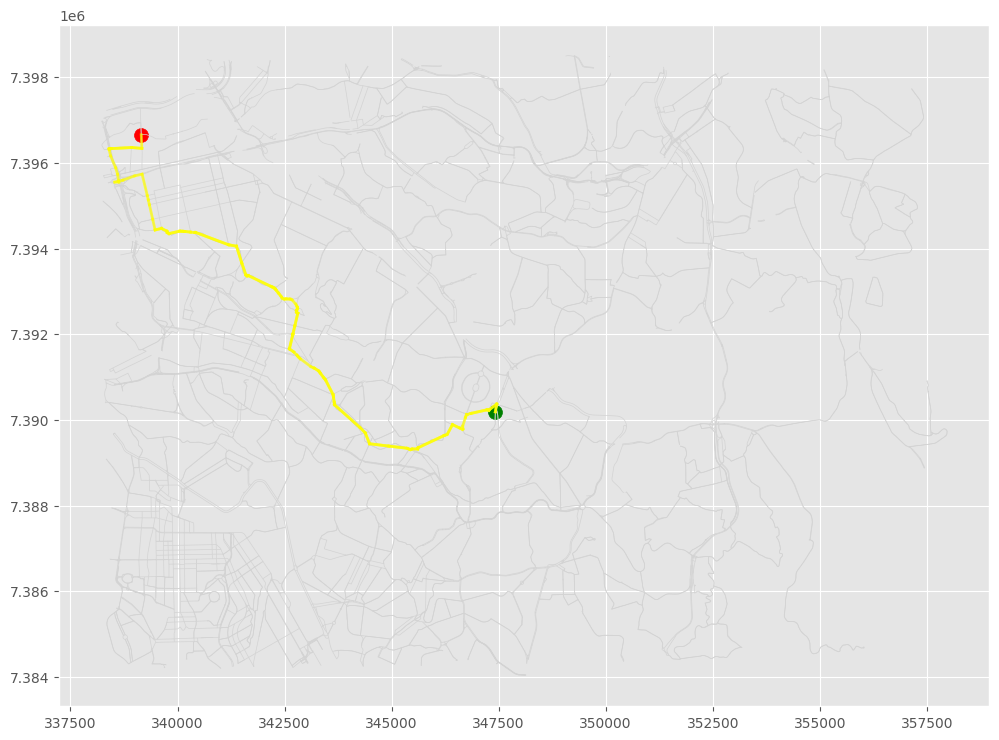

In [142]:
mostra_caminho_minimo(tempos_e_viagens_chuva_arquivo, 100, G_chuva1)

In [149]:
tempos_e_viagens_chuva_arquivo, sem_caminho = calcula_caminho_minimo2(centroides_dentro,'nearest_node_baseline', G_chuva1, 'travel_time_pct1_h_2768400_max',comentarios=True)


Iniciando o cálculo do caminho mínimo médio.
A referência fornecida para o cálculo do custo é nearest_node_baseline
Tempo de processamento: 5.28 segundos
Foram calculadas 709 viagens


In [154]:
tempos_e_viagens_chuva_arquivo2 = calcula_caminho_minimo2(centroides_dentro,'nearest_node_baseline', G_chuva1, 'travel_time_speed_kph',comentarios=True, revalida=True, sem_caminho=sem_caminho)


Iniciando o cálculo do caminho mínimo médio.
A referência fornecida para o cálculo do custo é nearest_node_baseline
Modo revalidação ativado. Ignorando 201 pares sem caminho.
Tempo de processamento: 5.46 segundos
Foram calculadas 709 viagens


In [151]:
add_edge_travel_times(G_chuva1, 'speed_kph', comentarios=True)


Iniciando o cálculo do tempo de viagem.

Cálculo do tempo de viagem concluído.

Removendo arestas cujo tempo de viagem é igual a infinito...

0 aresta(s) removida(s).



In [152]:
listar_atributos_arestas(G_chuva1)

{'access',
 'bridge',
 'est_width',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'pct1_h_2768400_max',
 'ref',
 'reversed',
 'speed_kph',
 'travel_time_pct1_h_2768400_max',
 'travel_time_speed_kph',
 'tunnel',
 'width'}

In [157]:
tempo_medio_viagem(tempos_e_viagens_chuva_arquivo2)

Tempo médio de viagem com chuva e ponderado: 11.27 minutos


np.float64(11.273039301384237)

### Processamento em lote


#### Facilidade para recarregar o GDF

In [170]:
# Carregar o grafo de um arquivo GraphML e o bounding box
try:
    G_baseline = ox.load_graphml(filepath='network_baseline_vel_updated.graphml')
    print('Grafo carregado com sucesso!')
except:
    print('Arquivo não encontrado')

try:
    bounding_box_baseline = gpd.read_file('bounding_box_bacia.json')
    print('Bounding box carregado com sucesso!')
except:
    print('Bounding box não encontrado')
    
node_baseline, edges_baseline = ox.graph_to_gdfs(G_baseline)

Grafo carregado com sucesso!
Bounding box carregado com sucesso!


In [171]:
# Verificar o CRS atual
print("CRS atual do edges_baseline:", edges_baseline.crs)

# Reprojetar para EPSG:31983
edges_baseline_reprojected = edges_baseline.to_crs(epsg=31983)

# Verificar se a reprojeção foi bem-sucedida
print("CRS do edges_baseline_reprojected:", edges_baseline_reprojected.crs)

CRS atual do edges_baseline: epsg:4326
CRS do edges_baseline_reprojected: EPSG:31983


#### Produzindo novas referências de velocidade

In [172]:
# Passo para ordenação dos arquivos em ordem crescente de tempo
import re
import os

# Obter a lista de arquivos TIFF no diretório
arquivos_tif = [f for f in os.listdir(clipado_path) if f.endswith(".tif")]
total_arquivos = len(arquivos_tif)  # Total de arquivos a serem processados

# Função para extrair o número que aparece depois de "h_" ou "max_"
def extrair_numero(nome):
    match = re.search(r'(?:h_|max_)(\d+)', nome)  # Captura o número após "h_" ou "max_"
    return int(match.group(1)) if match else float('inf')  # Retorna um número grande se não encontrar nada

# Ordenar a lista com base no número extraído
arquivos_ordenados = sorted(arquivos_tif, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in arquivos_ordenados:
    print(arquivo)


pct1_h_2692800_clp.tif
pct1_h_2696400_clp.tif
pct1_h_2700000_clp.tif
pct1_h_2703600_clp.tif
pct1_h_2707200_clp.tif
pct1_h_2710800_clp.tif
pct1_h_2714400_clp.tif
pct1_h_2718000_clp.tif
pct1_h_2721600_clp.tif
pct1_h_2725200_clp.tif
pct1_h_2728800_clp.tif
pct1_h_2732400_clp.tif
pct1_h_2736000_clp.tif
pct1_h_2739600_clp.tif
pct1_h_2743200_clp.tif
pct1_h_2746800_clp.tif
pct1_h_2750400_clp.tif
pct1_h_2754000_clp.tif
pct1_h_2757600_clp.tif
pct1_h_2761200_clp.tif
pct1_h_2764800_clp.tif
pct1_h_2768400_clp.tif
pct1_h_max_2768400_clp.tif


In [173]:
# Verificar que as colunas não estão presentes no GDF
edges_baseline_reprojected.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 8333 entries, (np.int64(597447), np.int64(25778775), np.int64(0)) to (np.int64(12013065742), np.int64(1269523805), np.int64(0))
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      8333 non-null   object  
 1   oneway     8333 non-null   bool    
 2   lanes      7167 non-null   object  
 3   ref        203 non-null    object  
 4   name       7047 non-null   object  
 5   highway    8333 non-null   object  
 6   maxspeed   2906 non-null   object  
 7   reversed   8333 non-null   object  
 8   length     8333 non-null   float64 
 9   geometry   8333 non-null   geometry
 10  speed_kph  8333 non-null   float64 
 11  bridge     270 non-null    object  
 12  access     37 non-null     object  
 13  tunnel     12 non-null     object  
 14  junction   263 non-null    object  
 15  est_width  38 non-null     object  
 16  width      13 non-null     object  
dt

In [175]:
# Iterar sobre os arquivos clipados
for index, filename in enumerate(arquivos_ordenados, start=1):  # Começa em 1
    print(f"\nProcessando arquivo {index} de {total_arquivos}: {filename}")

    # Extrair informações do nome do arquivo
    match = re.search(r'pct(?P<pct>\d+)_h(?:_max)?_(?P<value>\d+)_clp', filename)
    if match:
        pct = match.group('pct')  # Valor após "pct"
        value = match.group('value')  # Valor numérico
        is_max = '_max' in filename  # Verificar se "max" está presente

        # Criar o nome da coluna dinamicamente
        column_suffix = f"pct{pct}_h_{value}" + ("_max" if is_max else "")
        column_name = column_suffix  # Exemplo: "pct1_h_2692800" ou "pct1_h_max_2768400"
        #print(f"Coluna gerada: {column_name}")

        # Caminho completo do arquivo raster
        raster_path = os.path.join(clipado_path, filename)

        # Abrir o raster e extrair os dados
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)  # Ler a primeira banda do raster
            raster_transform = src.transform

        # Aplicar a função de ajuste e criar uma nova coluna
        edges_baseline_reprojected[column_name] = edges_baseline_reprojected.apply(
            adjust_speed_batch,
            axis=1,
            args=(raster_data, raster_transform, threshold, threshold_max, 'speed_kph')
        )

print("\nProcessamento concluído!\n")



Processando arquivo 1 de 23: pct1_h_2692800_clp.tif

Processando arquivo 2 de 23: pct1_h_2696400_clp.tif

Processando arquivo 3 de 23: pct1_h_2700000_clp.tif

Processando arquivo 4 de 23: pct1_h_2703600_clp.tif

Processando arquivo 5 de 23: pct1_h_2707200_clp.tif

Processando arquivo 6 de 23: pct1_h_2710800_clp.tif

Processando arquivo 7 de 23: pct1_h_2714400_clp.tif

Processando arquivo 8 de 23: pct1_h_2718000_clp.tif

Processando arquivo 9 de 23: pct1_h_2721600_clp.tif

Processando arquivo 10 de 23: pct1_h_2725200_clp.tif

Processando arquivo 11 de 23: pct1_h_2728800_clp.tif

Processando arquivo 12 de 23: pct1_h_2732400_clp.tif

Processando arquivo 13 de 23: pct1_h_2736000_clp.tif

Processando arquivo 14 de 23: pct1_h_2739600_clp.tif

Processando arquivo 15 de 23: pct1_h_2743200_clp.tif

Processando arquivo 16 de 23: pct1_h_2746800_clp.tif

Processando arquivo 17 de 23: pct1_h_2750400_clp.tif

Processando arquivo 18 de 23: pct1_h_2754000_clp.tif

Processando arquivo 19 de 23: pct1_h

In [176]:
# Verifique se as novas colunas foram adicionadas:
print(edges_baseline_reprojected.columns)

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'geometry', 'speed_kph', 'bridge', 'access',
       'tunnel', 'junction', 'est_width', 'width', 'pct1_h_2692800',
       'pct1_h_2696400', 'pct1_h_2700000', 'pct1_h_2703600', 'pct1_h_2707200',
       'pct1_h_2710800', 'pct1_h_2714400', 'pct1_h_2718000', 'pct1_h_2721600',
       'pct1_h_2725200', 'pct1_h_2728800', 'pct1_h_2732400', 'pct1_h_2736000',
       'pct1_h_2739600', 'pct1_h_2743200', 'pct1_h_2746800', 'pct1_h_2750400',
       'pct1_h_2754000', 'pct1_h_2757600', 'pct1_h_2761200', 'pct1_h_2764800',
       'pct1_h_2768400', 'pct1_h_2768400_max'],
      dtype='object')


#### Calcular os tempos de viagem

In [142]:
import geopandas as gpd
import pandas as pd

def add_edge_travel_times_gdf(gdf, referencia):
    referencia_corrigida = referencia.replace('_clp.tif', '') # Remove "_clp.tif" da referência. 
    nome = 'tt_' + referencia_corrigida  # Nome do novo atributo para tempo de viagem
    #print(f'Calculando os tempos de viagem para: ',nome)
    
    if nome not in gdf.columns:
        gdf[nome] = None  # Cria a coluna se não existir
        print(f'Coluna {nome} criada.')

    #print(f"GeoDataFrame contém {len(gdf)} linhas.")

    # Iterar sobre as linhas do GeoDataFrame
    for idx, row in gdf.iterrows():  # iterrows() é utilizado para iterar em DataFrames do geopandas
        length = row.get('length', 0)  # Certifique-se de que a coluna 'length' esteja definida no GDF
        vel_ref = row.get(referencia_corrigida, 0)  # Certifique-se de que a coluna de velocidade esteja no GDF
        #print(f'Índice: {idx}, Comprimento: {length}, Velocidade: {vel_ref}')

        if vel_ref == 0:
            travel_time_ref = 99999999  # Tempo de viagem muito elevado
        else:
            travel_time_ref = (length * 3.6) / vel_ref  # Converter para segundos
        
        gdf.at[idx, nome] = travel_time_ref  # Atribui o tempo de viagem à nova coluna

    # Identificar arestas com tempo de viagem infinito
    edges_to_remove = gdf[gdf[nome] == 99999999].index.tolist()
    if len(edges_to_remove)>0:
        #print(f'Arestas a serem removidas: {len(edges_to_remove)} de {len(edges_baseline_reprojected)}')
        # Remover as arestas com tempo de viagem infinito
        gdf = gdf.drop(edges_to_remove)
        #print(f'{len(edges_to_remove)} aresta(s) removida(s).\n')

    return gdf, len(edges_to_remove), len(edges_baseline_reprojected)

In [177]:
import numpy as np

def add_edge_travel_times_gdf2(gdf, referencia):
    referencia_corrigida = referencia.replace('_clp.tif', '')  # Remove "_clp.tif" da referência.
    nome = 'tt_' + referencia_corrigida  # Nome do novo atributo para tempo de viagem
    status_nome = 'status_via_' + referencia_corrigida  # Nome do novo atributo para status da via
    
    if nome not in gdf.columns:
        gdf[nome] = None  # Cria a coluna se não existir
        print(f'Coluna {nome} criada.')
    
    if status_nome not in gdf.columns:
        gdf[status_nome] = None  # Cria a coluna de status se não existir
        print(f'Coluna {status_nome} criada.')
    
    TRAVEL_TIME_MAX = 10**6  # Tempo muito alto (~11 dias)
    
    for idx, row in gdf.iterrows():
        length = row.get('length', 0)  # Comprimento da via
        vel_ref = row.get(referencia_corrigida, 0)  # Velocidade da via
        
        if vel_ref == 0:
            travel_time_ref = TRAVEL_TIME_MAX  # Define tempo muito alto
            gdf.at[idx, status_nome] = 'intransitável'
        else:
            travel_time_ref = (length * 3.6) / vel_ref  # Tempo em segundos
            gdf.at[idx, status_nome] = 'transitável'
        
        gdf.at[idx, nome] = travel_time_ref
    
    return gdf


In [144]:
import pandas as pd
import re

# Aplicando a função para adicionar o tempo de viagem
data_batch = []
data = 0

for column_name in arquivos_ordenados:
    edges_simulados, arestas_removidas, total_arestas = add_edge_travel_times_gdf(edges_baseline_reprojected, column_name)
    data_batch.append({
                    'index': data + 1,
                    'Referência': column_name.replace('_clp.tif', ''), # Remove "_clp.tif" da referência.
                    'Arestas removidas': arestas_removidas,
                    'Total de arestas' : total_arestas,
                })
    data += 1

edges_simulados, arestas_removidas, total_arestas = add_edge_travel_times_gdf(edges_baseline_reprojected, 'speed_kph') # Essa linha é necessária para construir o baseline no arquivo GDF
data_batch.append({
    'index': data + 1,
    'Referência': 'speed_kph',
    'Arestas removidas': arestas_removidas,
    'Total de arestas' : total_arestas,
})

# Criar DataFrame com os resultados
detalhes_arquivo_df = pd.DataFrame(data_batch)

# Criando a coluna "Max" com valor 0 por padrão
detalhes_arquivo_df["Max"] = 0

# Encontrar a linha que contém "max_"
linha_max = detalhes_arquivo_df[detalhes_arquivo_df["Referência"].str.contains("max_", na=False)]

if not linha_max.empty:
    # Extrair o número após "max_"
    match = re.search(r"max_(\d+)", linha_max["Referência"].values[0])
    
    if match:
        numero_max = match.group(1)  # Captura apenas o número após "max_"
        
        # Atualizar a linha correspondente ao número extraído, definindo "Max" como 1
        detalhes_arquivo_df.loc[detalhes_arquivo_df["Referência"].str.contains(f"h_{numero_max}", na=False), "Max"] = 1

# Remover a linha que contém "max_"
detalhes_arquivo_df = detalhes_arquivo_df[~detalhes_arquivo_df["Referência"].str.contains("max_", na=False)]

# Resetar o índice para manter organizado
detalhes_arquivo_df.reset_index(drop=True, inplace=True)

# Exibir o DataFrame atualizado
print(detalhes_arquivo_df)


    index      Referência  Arestas removidas  Total de arestas  Max
0       1  pct1_h_2692800                  0              8333    0
1       2  pct1_h_2696400                289              8333    0
2       3  pct1_h_2700000                418              8333    0
3       4  pct1_h_2703600                483              8333    0
4       5  pct1_h_2707200                497              8333    0
5       6  pct1_h_2710800                504              8333    0
6       7  pct1_h_2714400                523              8333    0
7       8  pct1_h_2718000                529              8333    0
8       9  pct1_h_2721600                548              8333    0
9      10  pct1_h_2725200                573              8333    0
10     11  pct1_h_2728800                619              8333    0
11     12  pct1_h_2732400                657              8333    0
12     13  pct1_h_2736000                659              8333    0
13     14  pct1_h_2739600                672    

In [178]:
import pandas as pd
import re

# Aplicando a função para adicionar o tempo de viagem
data_batch = []
data = 0

for column_name in arquivos_ordenados:
    edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, column_name)
    data_batch.append({
                    'index': data + 1,
                    'Referência': column_name.replace('_clp.tif', ''), # Remove "_clp.tif" da referência.
                })
    data += 1

edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, 'speed_kph') # Essa linha é necessária para construir o baseline no arquivo GDF
data_batch.append({
    'index': data + 1,
    'Referência': 'speed_kph',
})

# Criar DataFrame com os resultados
detalhes_arquivo_df = pd.DataFrame(data_batch)

# Criando a coluna "Max" com valor 0 por padrão
detalhes_arquivo_df["Max"] = 0

# Encontrar a linha que contém "max_"
linha_max = detalhes_arquivo_df[detalhes_arquivo_df["Referência"].str.contains("max_", na=False)]

if not linha_max.empty:
    # Extrair o número após "max_"
    match = re.search(r"max_(\d+)", linha_max["Referência"].values[0])
    
    if match:
        numero_max = match.group(1)  # Captura apenas o número após "max_"
        
        # Atualizar a linha correspondente ao número extraído, definindo "Max" como 1
        detalhes_arquivo_df.loc[detalhes_arquivo_df["Referência"].str.contains(f"h_{numero_max}", na=False), "Max"] = 1

# Remover a linha que contém "max_"
detalhes_arquivo_df = detalhes_arquivo_df[~detalhes_arquivo_df["Referência"].str.contains("max_", na=False)]

# Resetar o índice para manter organizado
detalhes_arquivo_df.reset_index(drop=True, inplace=True)

# Exibir o DataFrame atualizado
print(detalhes_arquivo_df)


Coluna tt_pct1_h_2692800 criada.
Coluna status_via_pct1_h_2692800 criada.
Coluna tt_pct1_h_2696400 criada.
Coluna status_via_pct1_h_2696400 criada.
Coluna tt_pct1_h_2700000 criada.
Coluna status_via_pct1_h_2700000 criada.
Coluna tt_pct1_h_2703600 criada.
Coluna status_via_pct1_h_2703600 criada.
Coluna tt_pct1_h_2707200 criada.
Coluna status_via_pct1_h_2707200 criada.
Coluna tt_pct1_h_2710800 criada.
Coluna status_via_pct1_h_2710800 criada.
Coluna tt_pct1_h_2714400 criada.
Coluna status_via_pct1_h_2714400 criada.
Coluna tt_pct1_h_2718000 criada.
Coluna status_via_pct1_h_2718000 criada.
Coluna tt_pct1_h_2721600 criada.
Coluna status_via_pct1_h_2721600 criada.
Coluna tt_pct1_h_2725200 criada.
Coluna status_via_pct1_h_2725200 criada.
Coluna tt_pct1_h_2728800 criada.
Coluna status_via_pct1_h_2728800 criada.
Coluna tt_pct1_h_2732400 criada.
Coluna status_via_pct1_h_2732400 criada.
Coluna tt_pct1_h_2736000 criada.
Coluna status_via_pct1_h_2736000 criada.
Coluna tt_pct1_h_2739600 criada.
Colun

In [184]:
edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, 'speed_kph') # Essa linha é necessária para construir o baseline no arquivo GDF

Coluna status_via_speed_kph criada.


In [185]:
# Verifique se as novas colunas foram adicionadas:

# Remover colunas que contêm "h_max_"
#edges_simulados = edges_simulados.drop(columns=[col for col in edges_simulados.columns if "h_max_" in col])

# Exibir as colunas restantes
print(edges_baseline_reprojected.columns)


Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'geometry', 'speed_kph', 'bridge', 'access',
       'tunnel', 'junction', 'est_width', 'width', 'pct1_h_2692800',
       'pct1_h_2696400', 'pct1_h_2700000', 'pct1_h_2703600', 'pct1_h_2707200',
       'pct1_h_2710800', 'pct1_h_2714400', 'pct1_h_2718000', 'pct1_h_2721600',
       'pct1_h_2725200', 'pct1_h_2728800', 'pct1_h_2732400', 'pct1_h_2736000',
       'pct1_h_2739600', 'pct1_h_2743200', 'pct1_h_2746800', 'pct1_h_2750400',
       'pct1_h_2754000', 'pct1_h_2757600', 'pct1_h_2761200', 'pct1_h_2764800',
       'pct1_h_2768400', 'pct1_h_2768400_max', 'tt_pct1_h_2692800',
       'status_via_pct1_h_2692800', 'tt_pct1_h_2696400',
       'status_via_pct1_h_2696400', 'tt_pct1_h_2700000',
       'status_via_pct1_h_2700000', 'tt_pct1_h_2703600',
       'status_via_pct1_h_2703600', 'tt_pct1_h_2707200',
       'status_via_pct1_h_2707200', 'tt_pct1_h_2710800',
       'status_via_pct1_h_2710800', 

In [186]:
# Filtra as colunas que começam com "tt"
status_columns = [col for col in edges_baseline_reprojected.columns if col.startswith("status")]

# Imprime os 10 primeiros valores dessas colunas
print(edges_baseline_reprojected[status_columns].head(10))

                        status_via_pct1_h_2692800 status_via_pct1_h_2696400  \
u        v          key                                                       
597447   25778775   0                 transitável               transitável   
25702002 2058923223 0                 transitável               transitável   
         25781819   0                 transitável               transitável   
25702039 4484722070 0                 transitável               transitável   
25778775 2350165221 0                 transitável               transitável   
         25781788   0                 transitável               transitável   
25781638 5474061764 0                 transitável               transitável   
25781667 2058923250 0                 transitável               transitável   
         25781670   0                 transitável               transitável   
25781670 135593268  0                 transitável               transitável   

                        status_via_pct1_h_2700000 s

In [187]:
# Filtra as colunas que começam com "tt"
tt_columns = [col for col in edges_simulados.columns if col.startswith("tt")]

# Imprime os 10 primeiros valores dessas colunas
print(edges_simulados[tt_columns].head(10))


                        tt_pct1_h_2692800 tt_pct1_h_2696400 tt_pct1_h_2700000  \
u        v          key                                                         
597447   25778775   0            33.98612          33.98612          33.98612   
25702002 2058923223 0            14.08764          14.08764          14.08764   
         25781819   0              46.791            46.791            46.791   
25702039 4484722070 0             2.16972           2.16972           2.16972   
25778775 2350165221 0            28.26066          28.26066          28.26066   
         25781788   0            11.19508          11.19508          11.19508   
25781638 5474061764 0            22.46322          22.46322          22.46322   
25781667 2058923250 0            21.68988          21.68988          21.68988   
         25781670   0            11.84088          11.84088          11.84088   
25781670 135593268  0             3.87984           3.87984           3.87984   

                        tt_

In [149]:
tt_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10 entries, (np.int64(597447), np.int64(25778775), np.int64(0)) to (np.int64(25781670), np.int64(135593268), np.int64(0))
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tt_pct1_h_2692800  10 non-null     object
 1   tt_pct1_h_2696400  10 non-null     object
 2   tt_pct1_h_2700000  10 non-null     object
 3   tt_pct1_h_2703600  10 non-null     object
 4   tt_pct1_h_2707200  10 non-null     object
 5   tt_pct1_h_2710800  10 non-null     object
 6   tt_pct1_h_2714400  10 non-null     object
 7   tt_pct1_h_2718000  10 non-null     object
 8   tt_pct1_h_2721600  10 non-null     object
 9   tt_pct1_h_2725200  10 non-null     object
 10  tt_pct1_h_2728800  10 non-null     object
 11  tt_pct1_h_2732400  10 non-null     object
 12  tt_pct1_h_2736000  10 non-null     object
 13  tt_pct1_h_2739600  10 non-null     object
 14  tt_pct1_h_2743200  10 non-null     obj

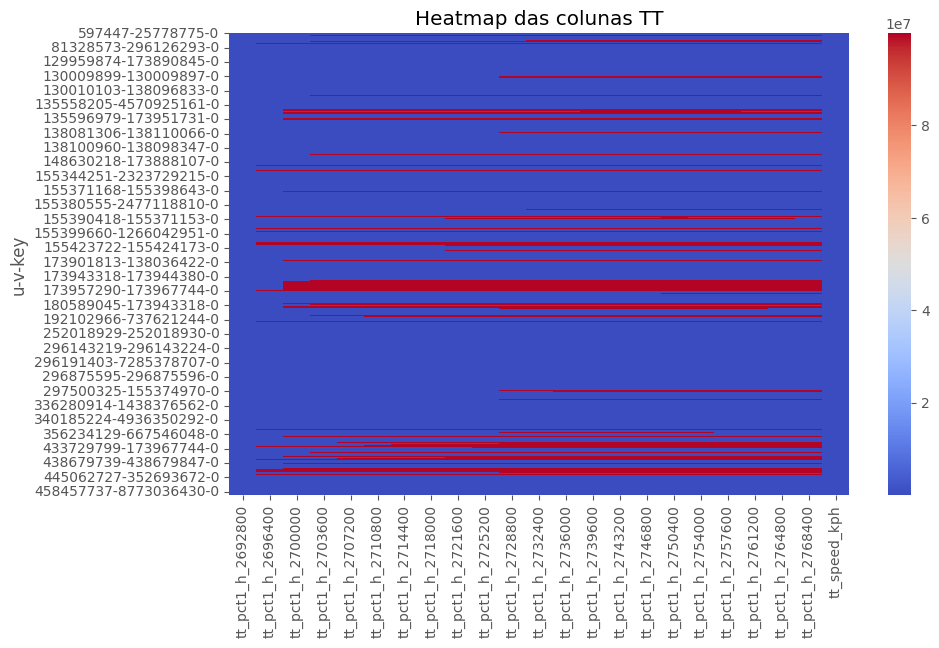

In [153]:
import seaborn as sns

# Seleciona os primeiros 10 valores das colunas "tt"
tt_data = edges_simulados[tt_columns].head(1000)

tt_data = tt_data.astype(float)

# Cria o heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(tt_data, cmap="coolwarm", annot=False, fmt=".1f")

plt.title("Heatmap das colunas TT")
plt.show()


In [130]:
edges_simulados.describe()

,length,speed_kph,pct1_h_2692800,pct1_h_2696400,pct1_h_2700000,pct1_h_2703600,pct1_h_2707200,pct1_h_2710800,pct1_h_2714400,pct1_h_2718000,...,pct1_h_2739600,pct1_h_2743200,pct1_h_2746800,pct1_h_2750400,pct1_h_2754000,pct1_h_2757600,pct1_h_2761200,pct1_h_2764800,pct1_h_2768400,pct1_h_2768400_max
count,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,...,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000,8333.000000
mean,200.067570,45.791432,45.791432,43.467126,42.637213,42.249804,42.176097,42.135999,42.091952,42.017670,...,40.964556,40.889851,40.846177,40.884452,40.918461,40.916216,40.959065,41.039343,41.124608,40.652923
std,319.217748,6.098739,6.098739,11.197064,12.546841,13.106424,13.222801,13.277276,13.347738,13.424823,...,14.667228,14.732479,14.796797,14.781565,14.727586,14.696739,14.656672,14.568449,14.463341,15.014949
min,0.168000,20.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.378000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
50%,73.927000,50.000000,50.000000,50.000000,50.000000,45.000000,45.000000,45.000000,45.000000,43.891029,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
75%,244.916000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
max,4891.373000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000


#### Construir um novo grafo, com todas referências de velocidades

MultiDiGraph with 4453 nodes and 8333 edges


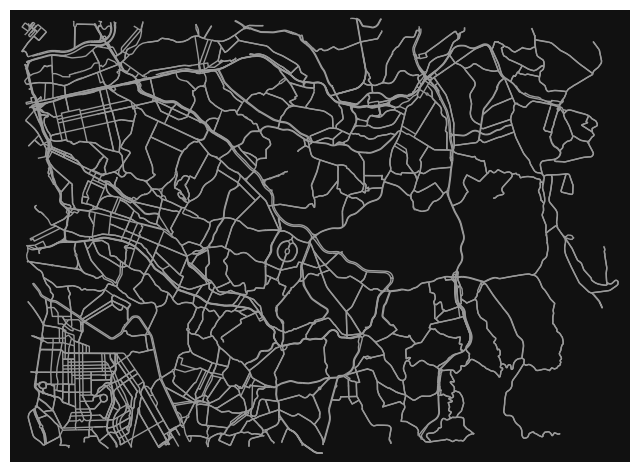

O sistema de referência de coordenadas do G_dinamico é: EPSG:31983


In [188]:
import osmnx as ox

# Garantir que os nós tenham colunas 'x' e 'y' extraídas da geometria
node_baseline["x"] = node_baseline.geometry.x
node_baseline["y"] = node_baseline.geometry.y

# Gerar o grafo e armazená-lo no dicionário
G_dinamico = ox.graph_from_gdfs(node_baseline, edges_simulados)

# Exibir o grafo
print(G_dinamico)
ox.plot_graph(G_dinamico)

# Verificar o sistema de referência de coordenadas
crs = G_dinamico.graph['crs']
print(f'O sistema de referência de coordenadas do G_dinamico é:', crs)

In [189]:
listar_atributos_arestas(G_dinamico)

{'access',
 'bridge',
 'est_width',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'pct1_h_2692800',
 'pct1_h_2696400',
 'pct1_h_2700000',
 'pct1_h_2703600',
 'pct1_h_2707200',
 'pct1_h_2710800',
 'pct1_h_2714400',
 'pct1_h_2718000',
 'pct1_h_2721600',
 'pct1_h_2725200',
 'pct1_h_2728800',
 'pct1_h_2732400',
 'pct1_h_2736000',
 'pct1_h_2739600',
 'pct1_h_2743200',
 'pct1_h_2746800',
 'pct1_h_2750400',
 'pct1_h_2754000',
 'pct1_h_2757600',
 'pct1_h_2761200',
 'pct1_h_2764800',
 'pct1_h_2768400',
 'pct1_h_2768400_max',
 'ref',
 'reversed',
 'speed_kph',
 'status_via_pct1_h_2692800',
 'status_via_pct1_h_2696400',
 'status_via_pct1_h_2700000',
 'status_via_pct1_h_2703600',
 'status_via_pct1_h_2707200',
 'status_via_pct1_h_2710800',
 'status_via_pct1_h_2714400',
 'status_via_pct1_h_2718000',
 'status_via_pct1_h_2721600',
 'status_via_pct1_h_2725200',
 'status_via_pct1_h_2728800',
 'status_via_pct1_h_2732400',
 'status_via_pct1_h_273600

#### Calcula caminhos mínimos

#### Função Calcula Caminho Mínimo 2

In [164]:
def calcula_caminho_minimo2(gdf_OD, referencia_OD, G, referencia, revalida=False, sem_caminho=None):
    if sem_caminho is None:
        sem_caminho = set()  # Inicializa corretamente um novo conjunto

    data = 0
    data_batch = []
    start_time = time.time()
    
    if revalida:
        print(f'Modo revalidação ativado. Ignorando {len(sem_caminho)} pares sem caminho.')

    for node1, node2 in itertools.combinations(gdf_OD[referencia_OD], 2):
        if node1 == node2:
            continue  # Ignorar pares onde origem e destino são iguais

        # Se revalida=True e o par está na lista sem_caminho, ignore
        if revalida and (node1, node2) in sem_caminho:
            continue
        try:
            # Obter o número de viagens entre node1 e node2
            num_trips = get_number_of_trips(node1, node2, referencia_OD, matriz_od_25)
            if num_trips > 0:
                # Calcular o caminho mínimo pelo tempo de viagem ponderado
                if node1 in G.nodes and node2 in G.nodes:
                    # Calcular o caminho mais curto
                    caminho, tempo = caminho_minimo(G, node1, node2, referencia)
                    weighted_time_rain = tempo * num_trips
                    data_batch.append({
                        'index': data + 1,
                        'Referência': referencia,
                        'Origem': node1,
                        'Destino': node2,
                        'Num_viagens': num_trips,
                        'Tempo de viagem (min)': tempo / 60,
                        'Número de nós': len(caminho),
                        'Percurso entre nós': list(caminho),
                        'Tempo ponderado (min)': weighted_time_rain / 60
                    })
                    data += 1
                else:
                    print(f"Nó(s) {node1} ou {node2} não encontrado(s) no grafo.")
                    continue
        except nx.NetworkXNoPath:
            # Se não houver caminho entre os nós, registre a ocorrência
            #print(f"Nenhum caminho encontrado entre {node1} e {node2}")
            sem_caminho.add((node1, node2))
            continue
            
    # Parar o cronômetro e calcular o tempo de processamento
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"Tempo de processamento: {processing_time:.2f} segundos")
    print(f'Foram calculadas {data} viagens')

    # Criar DataFrame com os resultados
    tempos_e_viagens_arquivo = pd.DataFrame(data_batch)
    print('Total de viagens sem conexão: ',len(sem_caminho))
    
    return tempos_e_viagens_arquivo, sem_caminho

In [205]:
def remover_arestas_intransitaveis(G, referencia):
    status_col = 'status_via_' + referencia.replace('tt_', '')

    # Verifica se o grafo possui arestas
    if not G.edges:
        print("O grafo não possui arestas. Nenhuma ação necessária.")
        return G

    # Obtém os atributos da primeira aresta para verificar se a chave existe
    _, _, primeira_aresta = next(iter(G.edges(data=True)), (None, None, {}))

    if status_col in primeira_aresta:
        # Filtra as arestas que são intransitáveis
        arestas_remover = [(u, v) for u, v, data in G.edges(data=True) if data.get(status_col, 'transitável') == 'intransitável']
    
        # Remove as arestas intransitáveis
        G.remove_edges_from(arestas_remover)
        print(f"Removidas {len(arestas_remover)} arestas intransitáveis.")
    else:
        print(f"Atributo '{status_col}' não encontrado no grafo. Nenhuma aresta removida.")

    return G


In [206]:
for arquivo in atributos_tt_ord:
    print(arquivo)
    remover_arestas_intransitaveis(G_dinamico, arquivo)

tt_pct1_h_2692800
Removidas 0 arestas intransitáveis.
tt_pct1_h_2696400
Removidas 289 arestas intransitáveis.
tt_pct1_h_2700000
Removidas 129 arestas intransitáveis.
tt_pct1_h_2703600
Removidas 65 arestas intransitáveis.
tt_pct1_h_2707200
Removidas 14 arestas intransitáveis.
tt_pct1_h_2710800
Removidas 8 arestas intransitáveis.
tt_pct1_h_2714400
Removidas 19 arestas intransitáveis.
tt_pct1_h_2718000
Removidas 6 arestas intransitáveis.
tt_pct1_h_2721600
Removidas 19 arestas intransitáveis.
tt_pct1_h_2725200
Removidas 25 arestas intransitáveis.
tt_pct1_h_2728800
Removidas 46 arestas intransitáveis.
tt_pct1_h_2732400
Removidas 38 arestas intransitáveis.
tt_pct1_h_2736000
Removidas 7 arestas intransitáveis.
tt_pct1_h_2739600
Removidas 13 arestas intransitáveis.
tt_pct1_h_2743200
Removidas 6 arestas intransitáveis.
tt_pct1_h_2746800
Removidas 13 arestas intransitáveis.
tt_pct1_h_2750400
Removidas 5 arestas intransitáveis.
tt_pct1_h_2754000
Removidas 2 arestas intransitáveis.
tt_pct1_h_27576

In [201]:
listar_atributos_arestas(G_dinamico)

{'access',
 'bridge',
 'est_width',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'pct1_h_2692800',
 'pct1_h_2696400',
 'pct1_h_2700000',
 'pct1_h_2703600',
 'pct1_h_2707200',
 'pct1_h_2710800',
 'pct1_h_2714400',
 'pct1_h_2718000',
 'pct1_h_2721600',
 'pct1_h_2725200',
 'pct1_h_2728800',
 'pct1_h_2732400',
 'pct1_h_2736000',
 'pct1_h_2739600',
 'pct1_h_2743200',
 'pct1_h_2746800',
 'pct1_h_2750400',
 'pct1_h_2754000',
 'pct1_h_2757600',
 'pct1_h_2761200',
 'pct1_h_2764800',
 'pct1_h_2768400',
 'pct1_h_2768400_max',
 'ref',
 'reversed',
 'speed_kph',
 'status_via_pct1_h_2692800',
 'status_via_pct1_h_2696400',
 'status_via_pct1_h_2700000',
 'status_via_pct1_h_2703600',
 'status_via_pct1_h_2707200',
 'status_via_pct1_h_2710800',
 'status_via_pct1_h_2714400',
 'status_via_pct1_h_2718000',
 'status_via_pct1_h_2721600',
 'status_via_pct1_h_2725200',
 'status_via_pct1_h_2728800',
 'status_via_pct1_h_2732400',
 'status_via_pct1_h_273600

In [ ]:
status_via_pct1_h_2692800',
 'status_via_pct1_h_2696400',
 'status_via_pct1_h_2700000',
 'status_via_pct1_h_2703600',
 'status_via_pct1_h_2707200',
 'status_via_pct1_h_2710800',
 'status_via_pct1_h_2714400',
 'status_via_pct1_h_2718000',
 'status_via_pct1_h_2721600',
 'status_via_pct1_h_2725200',
 'status_via_pct1_h_2728800',
 'status_via_pct1_h_2732400',
 'status_via_pct1_h_2736000',
 'status_via_pct1_h_2739600',
 'status_via_pct1_h_2743200',
 'status_via_pct1_h_2746800',
 'status_via_pct1_h_2750400',
 'status_via_pct1_h_2754000',
 'status_via_pct1_h_2757600',
 'status_via_pct1_h_2761200',
 'status_via_pct1_h_2764800',
 'status_via_pct1_h_2768400',

In [159]:
import numpy as np

def tempo_medio_viagem(arquivo):

    # Filtrar os valores finitos para tempo com peso e num_viagens
    finite_mask_baseline = np.isfinite(arquivo['Tempo ponderado (min)'])
    finite_tempos_e_viagens_baseline = arquivo[finite_mask_baseline]

    # Calcular o número total de viagens sem valores infinitos
    total_trips_weighted = finite_tempos_e_viagens_baseline['Num_viagens'].sum()

    # Calcular o tempo total sem peso ignorando valores infinitos
    total_time_weighted = finite_tempos_e_viagens_baseline['Tempo ponderado (min)'].sum()

    # Calcular o tempo médio de viagem ponderado
    mean_time_weighted = total_time_weighted / total_trips_weighted

    # Exibir os resultados
    #print(f"Tempo médio de viagem com chuva e ponderado: {mean_time_weighted:.2f} minutos")

    return mean_time_weighted

In [160]:
import itertools
import time
import networkx as nx
import pandas as pd

In [193]:
atributos_tt = set()
    
for _, _, dados in G_dinamico.edges(data=True):
    for atributo in dados.keys():
        if atributo.startswith("tt"):
            atributos_tt.add(atributo)

atributos_tt = [linha for linha in atributos_tt if "speed"not in linha]

#Ordenar a lista pelo número extraído
atributos_tt_ord = sorted(atributos_tt, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in atributos_tt_ord:
    print(arquivo)

# Limitando o tamanho da lista para facilitar o debug
#atributos_tt_ord = atributos_tt_ord[0:2]
print(atributos_tt_ord)

tt_pct1_h_2692800
tt_pct1_h_2696400
tt_pct1_h_2700000
tt_pct1_h_2703600
tt_pct1_h_2707200
tt_pct1_h_2710800
tt_pct1_h_2714400
tt_pct1_h_2718000
tt_pct1_h_2721600
tt_pct1_h_2725200
tt_pct1_h_2728800
tt_pct1_h_2732400
tt_pct1_h_2736000
tt_pct1_h_2739600
tt_pct1_h_2743200
tt_pct1_h_2746800
tt_pct1_h_2750400
tt_pct1_h_2754000
tt_pct1_h_2757600
tt_pct1_h_2761200
tt_pct1_h_2764800
tt_pct1_h_max_2768400
tt_pct1_h_2768400
['tt_pct1_h_2692800', 'tt_pct1_h_2696400', 'tt_pct1_h_2700000', 'tt_pct1_h_2703600', 'tt_pct1_h_2707200', 'tt_pct1_h_2710800', 'tt_pct1_h_2714400', 'tt_pct1_h_2718000', 'tt_pct1_h_2721600', 'tt_pct1_h_2725200', 'tt_pct1_h_2728800', 'tt_pct1_h_2732400', 'tt_pct1_h_2736000', 'tt_pct1_h_2739600', 'tt_pct1_h_2743200', 'tt_pct1_h_2746800', 'tt_pct1_h_2750400', 'tt_pct1_h_2754000', 'tt_pct1_h_2757600', 'tt_pct1_h_2761200', 'tt_pct1_h_2764800', 'tt_pct1_h_max_2768400', 'tt_pct1_h_2768400']


In [165]:
data = 0
data_batch = []

for coluna in atributos_tt_ord:
    print(coluna)
    sem_caminho2 = []
    tempos_e_viagens_chuva_domimgo2 = []
    tempos_e_viagens_chuva_domingo3 = []
    sem_caminho = set()

    # 1o Cálculo do caminho mínimo, sem chuva
    print("Antes da 1ª chamada:", sem_caminho)
    tempos_e_viagens_domingo, sem_caminho = calcula_caminho_minimo2(centroides_dentro,'nearest_node_baseline', G_dinamico, 'tt_speed_kph')
    print("Depois da 1ª chamada:", sem_caminho)
    tt_seco = tempo_medio_viagem(tempos_e_viagens_domingo)
    #print(tt_seco)

    # 2o Cálculo do caminho mínimo, com chuva
    tempos_e_viagens_domingo2, sem_caminho = calcula_caminho_minimo2(centroides_dentro,'nearest_node_baseline', G_dinamico, coluna, revalida=True, sem_caminho=sem_caminho)
    tt_chuva = tempo_medio_viagem(tempos_e_viagens_domingo2)
    #print(tt_chuva)
    #print(len(sem_caminho))

    # 3o Cálculo do caminho mínimo, sem chuva, mas com restrições de chuva
    tempos_e_viagens_domingo3, sem_caminho2 = calcula_caminho_minimo2(centroides_dentro,'nearest_node_baseline', G_dinamico, 'tt_speed_kph', revalida=True, sem_caminho=sem_caminho)
    tt_seco_modificado = tempo_medio_viagem(tempos_e_viagens_domingo3)
    #print(tt_seco_comchuva)

    data_batch.append({
                    'index': data + 1,
                    'Hora Simulada':coluna,
                    'TT sem chuva': tt_seco,
                    'TT com chuva': tt_chuva,
                    'TT sem chuva, modificado': tt_seco_modificado,
                })
    data += 1

# Criar DataFrame com os resultados
tempos_medios_arquivo = pd.DataFrame(data_batch)

tt_pct1_h_2692800
Antes da 1ª chamada: set()
Tempo de processamento: 4.12 segundos
Foram calculadas 428 viagens
Total de viagens sem conexão:  28
Depois da 1ª chamada: {(433999406, 8699569461), (242661092, 1662593611), (5345831151, 1662593611), (242661092, 8699569461), (1422532772, 8707027731), (2880970643, 1662593611), (1660722712, 1662593611), (1660722712, 8699569461), (129958225, 8699569461), (2780533002, 2583003908), (5334219098, 1662593611), (1422532772, 2488906786), (1422532772, 1705054810), (1677334673, 8699569461), (1422532772, 3830604147), (2106532284, 2583003908), (458457689, 8699569461), (2583003908, 1662593611), (242661092, 2583003908), (1705054810, 8699569461), (1422532772, 155371115), (8773249082, 8699569461), (155371196, 1662593611), (2106532284, 1662593611), (1422532772, 1679523477), (130009969, 8699569461), (3905134105, 1662593611), (5337689323, 1662593611)}
Modo revalidação ativado. Ignorando 28 pares sem caminho.
Tempo de processamento: 4.10 segundos
Foram calculadas

In [122]:
 # 3o Cálculo do caminho mínimo, sem chuva, mas com restrições de chuva
print(sem_caminho)
tempos_e_viagens_domingo3, sem_caminho2 = calcula_caminho_minimo2(centroides_dentro,'nearest_node_baseline', G_dinamico, 'tt_speed_kph', revalida=True, sem_caminho=sem_caminho)
tt_seco_modificado = tempo_medio_viagem(tempos_e_viagens_domingo3)
print(tt_seco_comchuva)

{(433999406, 8699569461), (242661092, 1662593611), (5345831151, 1662593611), (242661092, 8699569461), (1422532772, 8707027731), (2880970643, 1662593611), (1660722712, 1662593611), (1660722712, 8699569461), (129958225, 8699569461), (2780533002, 2583003908), (5334219098, 1662593611), (1422532772, 2488906786), (1422532772, 1705054810), (1677334673, 8699569461), (1422532772, 3830604147), (2106532284, 2583003908), (458457689, 8699569461), (2583003908, 1662593611), (242661092, 2583003908), (1705054810, 8699569461), (1422532772, 155371115), (8773249082, 8699569461), (155371196, 1662593611), (2106532284, 1662593611), (1422532772, 1679523477), (130009969, 8699569461), (3905134105, 1662593611), (5337689323, 1662593611)}
Modo revalidação ativado. Ignorando 28 pares sem caminho.
Tempo de processamento: 4.07 segundos
Foram calculadas 428 viagens
Total de viagens sem conexão:  28
7.259081659583624


In [167]:
tempos_medios_arquivo
    

,index,Hora Simulada,TT sem chuva,TT com chuva,"TT sem chuva, modificado"
0,1,tt_pct1_h_2692800,7.259082,7.259082,7.259082
1,2,tt_pct1_h_2696400,7.259082,274894.963027,7.259082


#### Montar o histograma

In [88]:
import pandas as pd

# Remover a linha que contém "max" na coluna 'Hora Simulada'
resiliencia_df = tempos_medios_arquivo[~tempos_medios_arquivo['Hora Simulada'].str.contains('max', na=False)]

# Extrair o número após "h_" e converter para inteiro para ordenação
resiliencia_df['h_value'] = resiliencia_df['Hora Simulada'].str.extract(r'h_(\d+)').astype(float)

# Ordenar o DataFrame pelo valor numérico extraído
resiliencia_df = resiliencia_df.sort_values(by='h_value', ascending=True).drop(columns=['h_value'])

# Resetar o índice após a ordenação
resiliencia_df = resiliencia_df.reset_index(drop=True)

# Exibir o DataFrame transformado
print(resiliencia_df)


    index      Hora Simulada  TT sem chuva  TT com chuva  \
0       8  tt_pct1_h_2692800      7.255198      7.255198   
1       7  tt_pct1_h_2696400      7.255198      8.968810   
2      20  tt_pct1_h_2700000      7.255198      9.797557   
3      18  tt_pct1_h_2703600      7.255198     10.174925   
4      14  tt_pct1_h_2707200      7.255198     10.181499   
5      12  tt_pct1_h_2710800      7.255198     10.197307   
6      16  tt_pct1_h_2714400      7.255198     10.453767   
7      15  tt_pct1_h_2718000      7.255198     10.484948   
8      10  tt_pct1_h_2721600      7.255198     10.446132   
9      17  tt_pct1_h_2725200      7.255198     10.560945   
10      6  tt_pct1_h_2728800      7.255198     10.857096   
11      4  tt_pct1_h_2732400      7.255198     11.215881   
12     21  tt_pct1_h_2736000      7.255198     11.524969   
13     22  tt_pct1_h_2739600      7.255198     11.999258   
14     11  tt_pct1_h_2743200      7.255198     12.094289   
15      5  tt_pct1_h_2746800      7.2551

/var/folders/8y/8z4lzw294m5c0kf05d8ww4r00000gn/T/ipykernel_54524/4292142791.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resiliencia_df['h_value'] = resiliencia_df['Hora Simulada'].str.extract(r'h_(\d+)').astype(float)


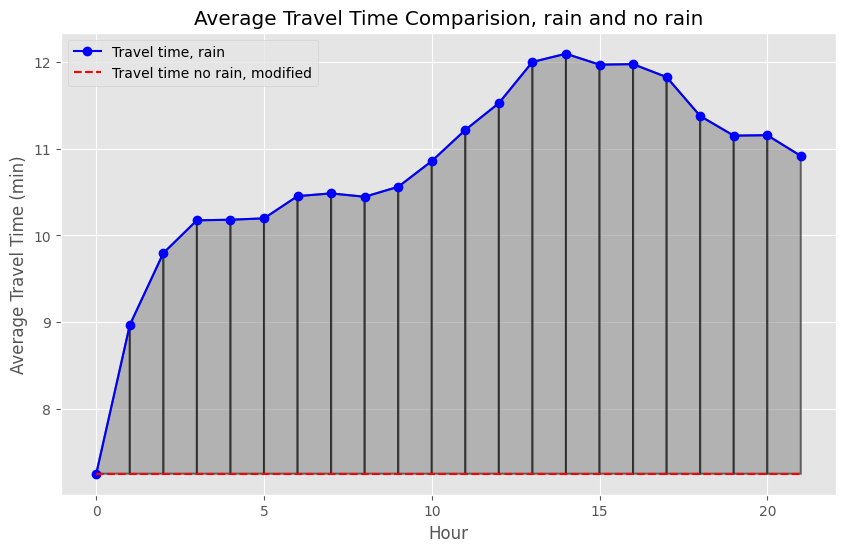

A resiliência (área total sob a curva): 75.14 


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Definir baseline como 'TT sem chuva, modificado'
baseline = resiliencia_df['TT sem chuva, modificado'].min()
area_total = 0

# Criar figura
plt.figure(figsize=(10, 6))

# Criar índices para plotagem
x = np.arange(len(resiliencia_df))
y = resiliencia_df['TT com chuva'].values
baseline_values = resiliencia_df['TT sem chuva, modificado'].values

# Plotar linha de TT com chuva
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Travel time, rain')

# Adicionar linha de baseline
plt.plot(x, baseline_values, linestyle='--', color='r', label='Travel time no rain, modified')

# Preencher trapézios entre baseline e TT com chuva
for i in range(len(x) - 1):
    x_trapezoid = [x[i], x[i], x[i+1], x[i+1]]
    y_trapezoid = [baseline_values[i], y[i], y[i+1], baseline_values[i]]

    # Preencher o trapézio
    plt.fill(x_trapezoid, y_trapezoid, 'gray', alpha=0.5, edgecolor='k', linewidth=1.5)

    # Calcular a área do trapézio
    base1 = abs(y[i] - baseline_values[i])
    base2 = abs(y[i+1] - baseline_values[i+1])
    altura = 1  # Como o eixo X é discreto, altura = 1 unidade
    area_trap = 0.5 * (base1 + base2) * altura
    area_total += area_trap

# Ajustes do gráfico
plt.xlabel('Hour')
plt.ylabel('Average Travel Time (min)')
plt.title('Average Travel Time Comparision, rain and no rain')
plt.legend()
plt.grid(True)

# Exibir gráfico
plt.show()

# Exibir área total sob a curva
print(f"A resiliência (área total sob a curva): {area_total:.2f} ")
